In [46]:
import matplotlib.pyplot as plt
import mne 
import numpy as np
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

from scipy.stats import spearmanr
from scipy.ndimage import gaussian_filter

from mne.stats import spatio_temporal_cluster_test, f_mway_rm, f_threshold_mway_rm

In [4]:
path = '/home/common/bonaiuto/stop_go_bursts/derivatives/Dataset_1/'

# combine bursts_all_results and bursts_all_results_cue
bursts_all_results_laplac = np.load(f'{path}/bursts_all_results_laplac.npy', allow_pickle=True)

In [5]:
all_bursts={
    'trial': [],
    'waveform': [],
    'peak_freq': [],
    'peak_amp_iter': [],
    'peak_amp_base': [],
    'peak_time': [],
    'peak_adjustment': [],
    'fwhm_freq': [],
    'fwhm_time': [],
    'polarity': [],
    'waveform_times': [],
    'condition': [],
    'electrode': [],
    'subject': [],
    'experiment': [],
    'epochs': []
}
for bursts in bursts_all_results_laplac:
    for key in bursts:
        if not key=='waveform_times':
            all_bursts[key].extend(bursts[key])
        else:
            all_bursts[key]=bursts[key]
            
for key in all_bursts:
    all_bursts[key]=np.array(all_bursts[key])

In [6]:
c3_idx=(all_bursts['electrode']=='C3')
f4_idx=(all_bursts['electrode']=='F4')


In [19]:
# Initialize an empty list to store the mean waveforms
mean_waveforms_laplac_C3 = []

# Loop through unique subjects in the dictionary
unique_subjects = np.unique(all_bursts['subject'])
for subject in unique_subjects:
    # Extract waveforms corresponding to the current subject
    subject_waveforms = all_bursts['waveform'][c3_idx & (all_bursts['subject'] == subject),]*1e3
    
    # Calculate the mean waveform for the subject
    mean_waveform = np.mean(subject_waveforms, axis=0)
    
    # Append the mean waveform to the list
    mean_waveforms_laplac_C3.append(mean_waveform)

# Convert the list to a NumPy array
matrix_mean_waveforms_laplac_C3 = np.array(mean_waveforms_laplac_C3)


# Initialize an empty list to store the mean waveforms
mean_waveforms_laplac_F4 = []

# Loop through unique subjects in the dictionary
unique_subjects = np.unique(all_bursts['subject'])
for subject in unique_subjects:
    # Extract waveforms corresponding to the current subject
    subject_waveforms = all_bursts['waveform'][f4_idx & (all_bursts['subject'] == subject),]*1e3
    
    # Calculate the mean waveform for the subject
    mean_waveform = np.mean(subject_waveforms, axis=0)
    
    # Append the mean waveform to the list
    mean_waveforms_laplac_F4.append(mean_waveform)

# Convert the list to a NumPy array
matrix_mean_waveforms_laplac_F4 = np.array(mean_waveforms_laplac_F4)

Using a threshold of 2.200985
stat_fun(H1): min=-3.782782 max=3.706649
Running initial clustering
Found 8 clusters
Permuting 999 times...


  0%|          |  : 0/999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


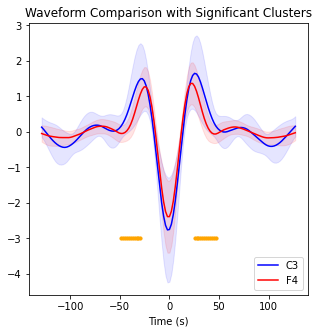

In [21]:
data = matrix_mean_waveforms_laplac_C3 - matrix_mean_waveforms_laplac_F4

# Perform cluster-based permutation test
T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_1samp_test(
    data, n_permutations=1000
)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Plot mean waveforms
ax.plot(
    all_bursts['waveform_times']*1e3,
    np.mean(matrix_mean_waveforms_laplac_C3, axis=0),
    label="C3",
    color="blue",
)
ax.plot(
    all_bursts['waveform_times']*1e3,
    np.mean(matrix_mean_waveforms_laplac_F4, axis=0),
    label="F4",
    color="red",
)

# Add shaded area using SEM around the mean waveform
ax.fill_between(
    all_bursts['waveform_times']*1e3,
    np.mean(matrix_mean_waveforms_laplac_C3, axis=0) - np.std(matrix_mean_waveforms_laplac_C3, axis=0),
    np.mean(matrix_mean_waveforms_laplac_C3, axis=0) + np.std(matrix_mean_waveforms_laplac_C3, axis=0),
    color="blue",
    alpha=0.1,
)
ax.fill_between(
    all_bursts['waveform_times']*1e3,
    np.mean(matrix_mean_waveforms_laplac_F4, axis=0) - np.std(matrix_mean_waveforms_laplac_F4, axis=0),
    np.mean(matrix_mean_waveforms_laplac_F4, axis=0) + np.std(matrix_mean_waveforms_laplac_F4, axis=0),
    color="red",
    alpha=0.1,
)

# Plot significant clusters as dots
for i_c, c in enumerate(clusters):
    c = c[0]
    if cluster_p_values[i_c] < 0.05:
        # Add dots at the time points of the cluster
        cluster_times = all_bursts['waveform_times'][c]*1e3
        cluster_midpoint = -3  # Midpoint between the offsets for clarity
        ax.scatter(cluster_times, [cluster_midpoint] * len(cluster_times), color='orange', label='Significant Cluster' if i_c == 0 else "", s=10)

# Finalize plot

ax.set_xlabel("Time (s)")
ax.set_title("Waveform Comparison with Significant Clusters")
ax.legend(loc='lower right')
plt.show()


9 components explain 82.06506915775284% of variance


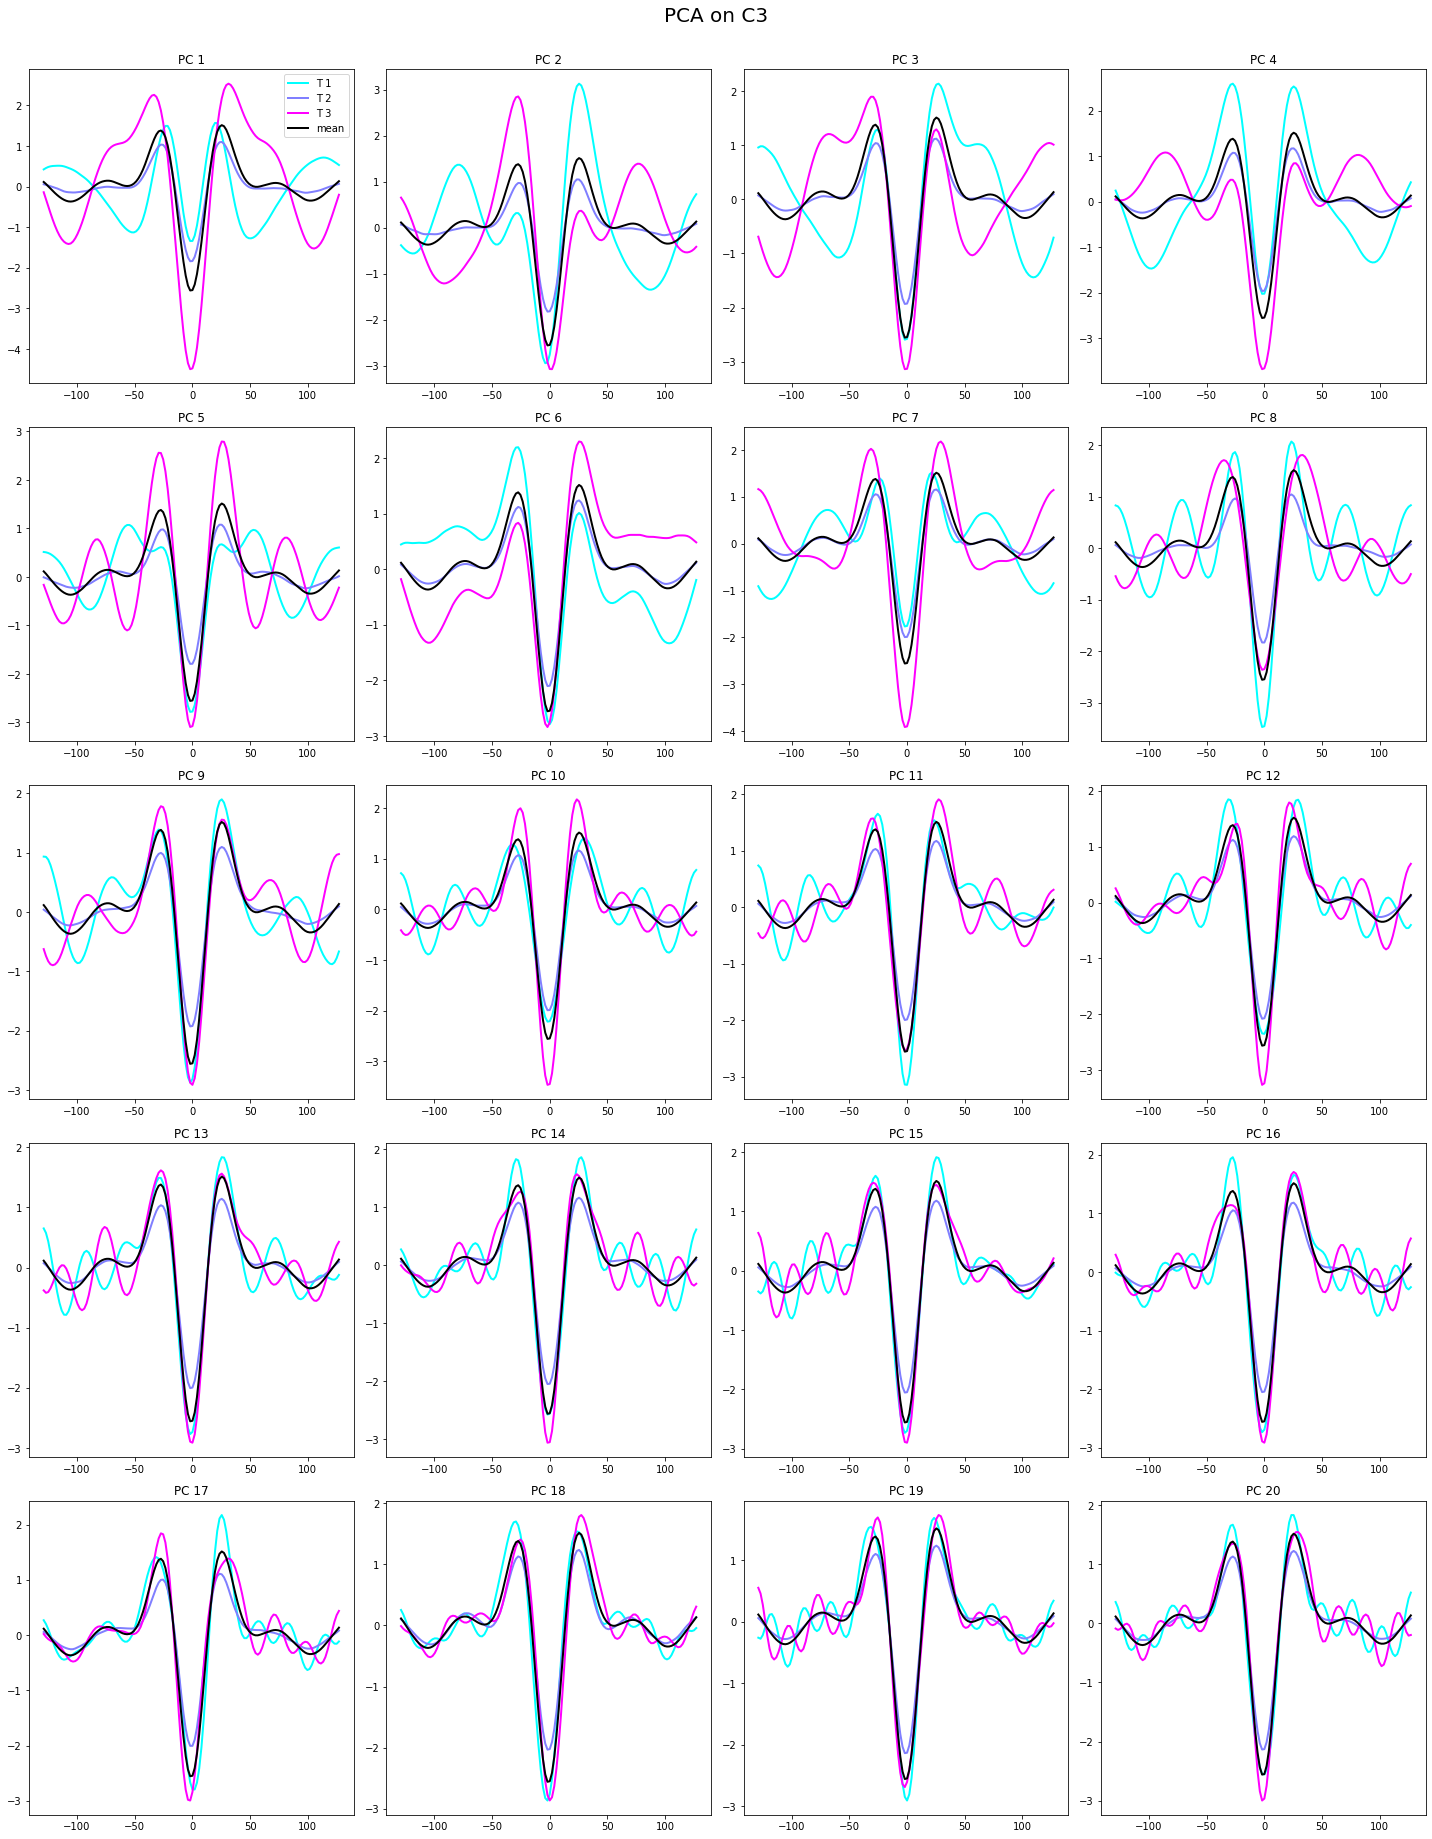

In [22]:
waveforms_laplac_C3=all_bursts['waveform'][c3_idx,:]

# Scaling and PCA on the entire dataset
model_laplac_C3 = PCA(n_components=20)
scaler_laplac_C3 = RobustScaler().fit(waveforms_laplac_C3)
waveforms_laplac_C3_std = scaler_laplac_C3.transform(waveforms_laplac_C3)
model_laplac_C3.fit(waveforms_laplac_C3_std)

cum_var_exp=np.cumsum(model_laplac_C3.explained_variance_ratio_)
if len(np.where(cum_var_exp>=.8)[0]):
    idx=np.min(np.where(cum_var_exp>=.8)[0])
else:
    idx=len(cum_var_exp)-1
print('{} components explain {}% of variance'.format(idx+1,cum_var_exp[idx]*100))

# Transforming the data to get principal components
pc_scores_laplac_C3 = model_laplac_C3.transform(waveforms_laplac_C3_std)  # all the bursts x 20 components
pc_labels_laplac_C3 = ["PC_{}".format(i + 1) for i in range(pc_scores_laplac_C3.shape[1])]

# Quartile calculation
quartiles_laplac_C3 = np.linspace(0, 100, num=4)
quartiles_laplac_C3 = list(zip(quartiles_laplac_C3[:-1], quartiles_laplac_C3[1:]))
col_range_laplac_C3 = plt.cm.cool(np.linspace(0, 1, num=len(quartiles_laplac_C3)))
mean_waveform_laplac_C3 = np.mean(waveforms_laplac_C3, axis=0)

# Plotting the PCA results
f_laplac_C3, ax_laplac_C3 = plt.subplots(5, 4, figsize=(20, 25))
ax_laplac_C3 = ax_laplac_C3.flatten()
for pc_ix, pc in enumerate(pc_labels_laplac_C3):
    ax_laplac_C3[pc_ix].set_title(pc.replace("_", " "))  # Set the nice title
    scores_laplac_C3 = pc_scores_laplac_C3[:,pc_ix]  # Select the appropriate principal component from the dataframe
    q_maps_laplac_C3 = []
    for q_ix, (b, e) in enumerate(quartiles_laplac_C3):
        q_map_laplac_C3 = (scores_laplac_C3 > np.percentile(scores_laplac_C3, b)) & (scores_laplac_C3 <= np.percentile(scores_laplac_C3, e))  # Create a boolean map to select the waveforms_laplac_C3
        q_mean_laplac_C3 = np.mean(waveforms_laplac_C3[q_map_laplac_C3], axis=0)
        ax_laplac_C3[pc_ix].plot(all_bursts['waveform_times']*1e3, q_mean_laplac_C3*1e3, lw=2, c=col_range_laplac_C3[q_ix], label="T {}".format(q_ix + 1))
    ax_laplac_C3[pc_ix].plot(all_bursts['waveform_times']*1e3, mean_waveform_laplac_C3*1e3, lw=2, c="black", label="mean")
ax_laplac_C3[0].legend(fontsize=10)
plt.tight_layout()
plt.suptitle("PCA on C3", fontsize=20, y=1.02)
plt.show()


13 components explain 80.18480279886734% of variance


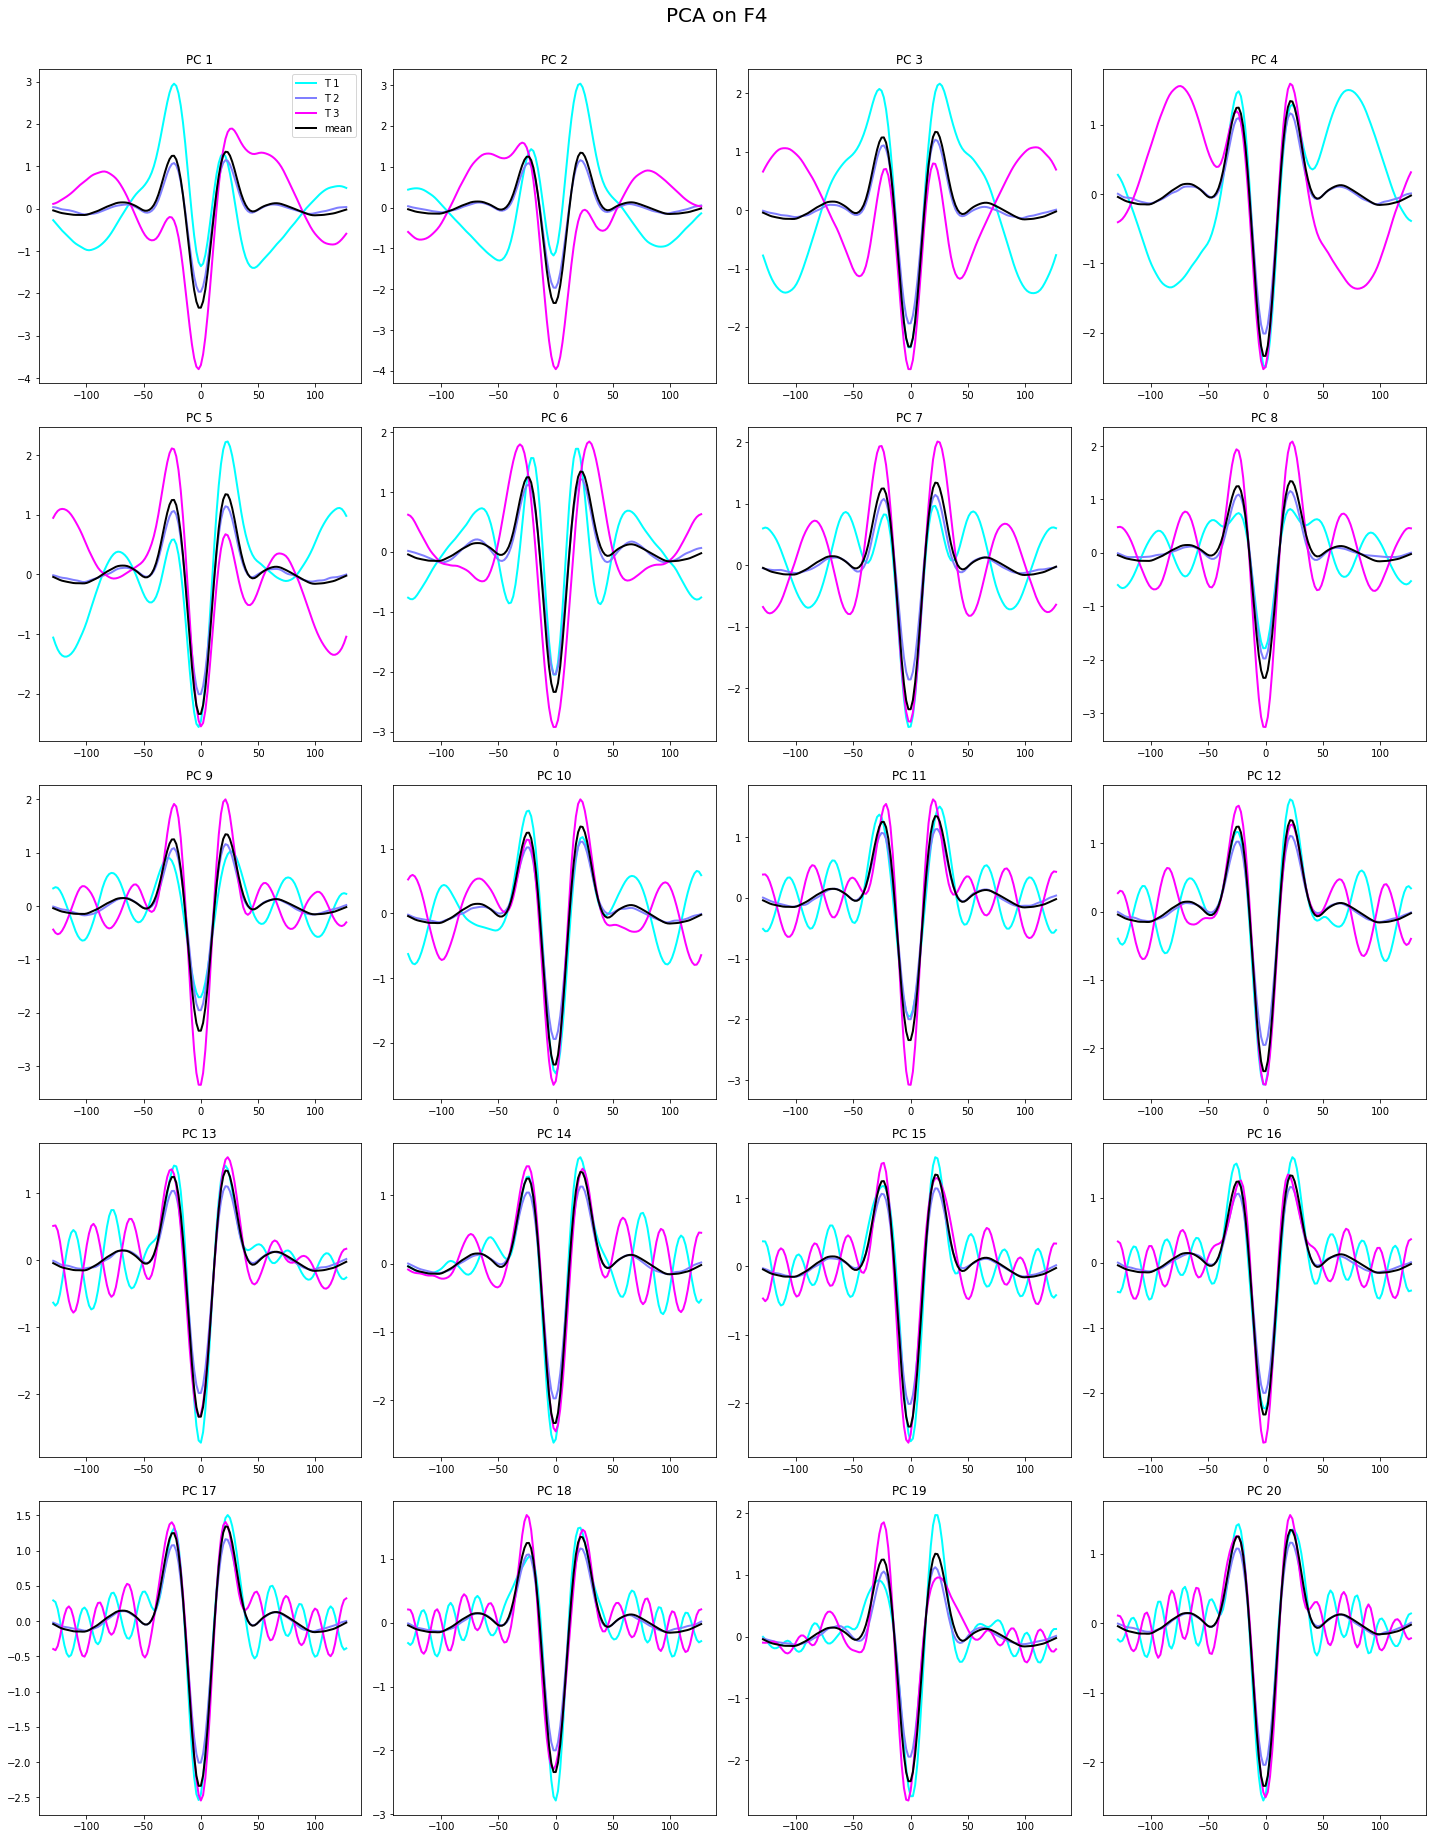

In [23]:
waveforms_laplac_F4=all_bursts['waveform'][f4_idx,:]

# Scaling and PCA on the entire dataset
model_laplac_F4 = PCA(n_components=20)
scaler_laplac_F4 = RobustScaler().fit(waveforms_laplac_F4)
waveforms_laplac_F4_std = scaler_laplac_F4.transform(waveforms_laplac_F4)
model_laplac_F4.fit(waveforms_laplac_F4_std)

cum_var_exp=np.cumsum(model_laplac_F4.explained_variance_ratio_)
if len(np.where(cum_var_exp>=.8)[0]):
    idx=np.min(np.where(cum_var_exp>=.8)[0])
else:
    idx=len(cum_var_exp)-1
print('{} components explain {}% of variance'.format(idx+1,cum_var_exp[idx]*100))

# Transforming the data to get principal components
pc_scores_laplac_F4 = model_laplac_F4.transform(waveforms_laplac_F4_std)  # all the bursts x 20 components
pc_labels_laplac_F4 = ["PC_{}".format(i + 1) for i in range(pc_scores_laplac_F4.shape[1])]

# Quartile calculation
quartiles_laplac_F4 = np.linspace(0, 100, num=4)
quartiles_laplac_F4 = list(zip(quartiles_laplac_F4[:-1], quartiles_laplac_F4[1:]))
col_range_laplac_F4 = plt.cm.cool(np.linspace(0, 1, num=len(quartiles_laplac_F4)))
mean_waveform_laplac_F4 = np.mean(waveforms_laplac_F4, axis=0)

# Plotting the PCA results
f_laplac_F4, ax_laplac_F4 = plt.subplots(5, 4, figsize=(20, 25))
ax_laplac_F4 = ax_laplac_F4.flatten()
for pc_ix, pc in enumerate(pc_labels_laplac_F4):
    ax_laplac_F4[pc_ix].set_title(pc.replace("_", " "))  # Set the nice title
    scores_laplac_F4 = pc_scores_laplac_F4[:,pc_ix]  # Select the appropriate principal component from the dataframe
    q_maps_laplac_F4 = []
    for q_ix, (b, e) in enumerate(quartiles_laplac_F4):
        q_map_laplac_F4 = (scores_laplac_F4 > np.percentile(scores_laplac_F4, b)) & (scores_laplac_F4 <= np.percentile(scores_laplac_F4, e))  # Create a boolean map to select the waveforms_laplac_C3
        q_mean_laplac_F4 = np.mean(waveforms_laplac_F4[q_map_laplac_F4], axis=0)
        ax_laplac_F4[pc_ix].plot(all_bursts['waveform_times']*1e3, q_mean_laplac_F4*1e3, lw=2, c=col_range_laplac_F4[q_ix], label="T {}".format(q_ix + 1))
    ax_laplac_F4[pc_ix].plot(all_bursts['waveform_times']*1e3, mean_waveform_laplac_F4*1e3, lw=2, c="black", label="mean")
ax_laplac_F4[0].legend(fontsize=10)
plt.tight_layout()
plt.suptitle("PCA on F4", fontsize=20, y=1.02)
plt.show()


In [24]:
all_burst_pc_scores=np.zeros((all_bursts['waveform'].shape[0],20))
all_burst_pc_scores[c3_idx,:]=pc_scores_laplac_C3
all_burst_pc_scores[f4_idx,:]=pc_scores_laplac_F4

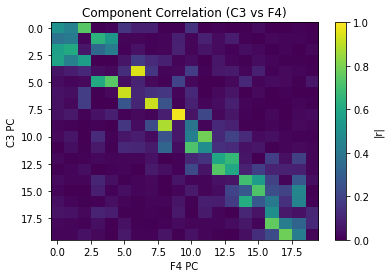

In [25]:
# Parameters
pcs_to_analyze_c = 20
min_pcs = min(model_laplac_C3.components_.shape[0], model_laplac_F4.components_.shape[0])

# Calculate the component correlation matrix
comp_corrmat_C3_F4 = np.zeros((min_pcs, min_pcs))
for i in range(min_pcs):
    for j in range(min_pcs):
        comp_corrmat_C3_F4[i, j] = np.abs(spearmanr(model_laplac_C3.components_[i, :], model_laplac_F4.components_[j, :])[0])

# Plot the correlation matrix
plt.imshow(comp_corrmat_C3_F4, aspect='auto', origin='upper', cmap='viridis', vmin=0, vmax=1)
plt.colorbar(label='|r|')
plt.xlabel('F4 PC')
plt.ylabel('C3 PC')
plt.title('Component Correlation (C3 vs F4)')
plt.show()


In [26]:
# Save the fitted scaler and PCA objects
with open('robust_scaler_c3.pkl', 'wb') as scaler_file:
    pickle.dump(scaler_laplac_C3, scaler_file)

with open('pca_object_c3.pkl', 'wb') as pca_file:
    pickle.dump(model_laplac_C3, pca_file)
    
with open('robust_scaler_f4.pkl', 'wb') as scaler_file:
    pickle.dump(scaler_laplac_F4, scaler_file)

with open('pca_object_f4.pkl', 'wb') as pca_file:
    pickle.dump(model_laplac_F4, pca_file)

In [27]:
def shuffle_array(array):
    X_array = array.copy()
    rows, columns = array.shape
    for col in range(columns):
        ixes = np.arange(0,rows)
        np.random.shuffle(ixes)
        X_array[:,col] = X_array[:,col][ixes]
    return X_array

def shuffle_array_range(array, ranges):
    X_array = []
    for x1, x2 in ranges:
        X = wvf[:,x1:x2]
        np.random.shuffle(X)
        X_array.append(X)
    return np.hstack(X_array)

def get_num_components(waveforms, n_comps):
    # robust scaling
    waveforms_scaled = RobustScaler().fit_transform(waveforms)

    # main PCA fitting
    pca_full = PCA(n_components=n_comps)
    pcs_full = pca_full.fit_transform(waveforms_scaled)
    var_full = pca_full.explained_variance_ratio_ 

    # robustness of pca components
    no_of_iter = 100
    pca_vars = []
    for i in range(no_of_iter):
        shuffled_wvf = shuffle_array(waveforms_scaled)

        pca_shuff = PCA(n_components=n_comps)
        pca_shuff.fit(shuffled_wvf)
        pca_vars.append(pca_shuff.explained_variance_ratio_)        
    del shuffled_wvf
    pca_vars=np.array(pca_vars)

    # getting the magic number
    results = np.sum(var_full>pca_vars, axis=0) / no_of_iter
    threshold=1-(.05/n_comps)
    PCS_to_analyse = np.where(results > threshold)[0]
    return PCS_to_analyse

In [28]:
c3_shuffling_results=get_num_components(all_bursts['waveform'][c3_idx,:], 20)
print(f'C3 non-noise PCs: {c3_shuffling_results}')

f4_shuffling_results=get_num_components(all_bursts['waveform'][f4_idx,:], 20)
print(f'F4 non-noise PCs: {f4_shuffling_results}')

C3 non-noise PCs: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
F4 non-noise PCs: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [29]:
def score_var_permutation_test(pcs, b_idx):
    n_permutations = 1000
    time_bins = np.arange(-1, 2, 0.005)
    bin_centers = 0.5 * (time_bins[:-1] + time_bins[1:])
    n_bins = len(time_bins) - 1
    subjects = np.unique(all_bursts['subject'])
    
    def safe_digitize(times, bins):
        idx = np.digitize(times, bins=bins) - 1  
        idx[idx < 0] = 0
        idx[idx >= n_bins] = n_bins - 1
        return idx

    subject_data = {}
    for subject in subjects:
        subj_mask = (all_bursts['subject'] == subject) & b_idx
        if not np.any(subj_mask):
            continue

        times = all_bursts['peak_time'][subj_mask]
        scores = all_burst_pc_scores[subj_mask, :]
        bin_idx = safe_digitize(times, time_bins)

        subject_data[subject] = {
            'bin_idx': bin_idx,
            'scores': scores
        }

    observed_variances = {}
    pc_means_over_time = {}

    for pc in pcs:
        subject_bin_means = []

        for subject in subject_data:
            bin_idx = subject_data[subject]['bin_idx']
            scores = subject_data[subject]['scores'][:, pc]

            bin_sum = np.bincount(bin_idx, weights=scores, minlength=n_bins)
            bin_count = np.bincount(bin_idx, minlength=n_bins)

            # Compute mean per bin
            subj_means = np.divide(bin_sum, bin_count, out=np.zeros(n_bins), where=(bin_count > 0))
            subject_bin_means.append(subj_means)

        subject_bin_means = np.array(subject_bin_means)
        mean_over_subs = np.mean(subject_bin_means, axis=0)
        pc_means_over_time[pc] = mean_over_subs

        observed_variances[pc] = np.var(mean_over_subs[1:-1])

    null_variances = {pc: [] for pc in pcs}

    for _ in range(n_permutations):

        # Shuffle each subject's bin indices once
        perm_bin_idx = {}
        for subject in subject_data:
            old_idx = subject_data[subject]['bin_idx']
            perm_bin_idx[subject] = np.random.permutation(old_idx)

        # Use these permuted indices for all PCs
        for pc in pcs:
            subject_bin_means = []

            for subject in subject_data:
                new_idx = perm_bin_idx[subject]
                scores = subject_data[subject]['scores'][:, pc]

                bin_sum = np.bincount(new_idx, weights=scores, minlength=n_bins)
                bin_count = np.bincount(new_idx, minlength=n_bins)

                subj_means = np.divide(bin_sum, bin_count, out=np.zeros(n_bins), where=(bin_count > 0))
                subject_bin_means.append(subj_means)

            mean_over_subs = np.mean(subject_bin_means, axis=0)
            null_variances[pc].append(np.var(mean_over_subs[1:-1]))

    p_vals={}
    for pc in observed_variances:
        p_vals[pc] = (np.sum(np.abs(null_variances[pc]) >= np.abs(observed_variances[pc])) + 1) / (n_permutations + 1)
    significant_pcs = [
        pc for pc in pcs if p_vals[pc]*len(pcs) < 0.05
    ]

    print(f"Significant PCs: {significant_pcs}")

    num_pcs = len(pcs)
    num_rows = int(np.ceil(num_pcs / 4))
    fig, axs = plt.subplots(num_rows, 4, figsize=(20, 5 * num_rows))
    axs = axs.flatten()

    for i, pc in enumerate(pcs):
        ax = axs[i]
        bin_means = pc_means_over_time[pc]

        subj_bin_means = []
        for subject in subject_data:
            idx = subject_data[subject]['bin_idx']
            sc = subject_data[subject]['scores'][:, pc]
            s_sum = np.bincount(idx, weights=sc, minlength=n_bins)
            s_cnt = np.bincount(idx, minlength=n_bins)
            subj_bin_means.append(np.divide(s_sum, s_cnt, out=np.zeros(n_bins), where=(s_cnt > 0)))

        subj_bin_means = np.array(subj_bin_means)
        bin_sems = np.std(subj_bin_means, axis=0) / np.sqrt(len(subject_data))

        color = 'red' if pc in significant_pcs else 'black'
        ax.plot(bin_centers, bin_means, color=color)
        ax.fill_between(bin_centers, bin_means - bin_sems, bin_means + bin_sems, alpha=0.2, color='gray')
        ax.set_xlim(bin_centers[0], bin_centers[-1])
        ax.set_title(f"PC {pc+1}" + (" *" if pc in significant_pcs else ""))

        if i % 4 == 0:
            ax.set_ylabel("Mean Score")
        if i >= (num_pcs - 4):
            ax.set_xlabel("Time (s)")

    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

    return observed_variances, significant_pcs

Significant PCs: [0, 4, 6, 7, 9]


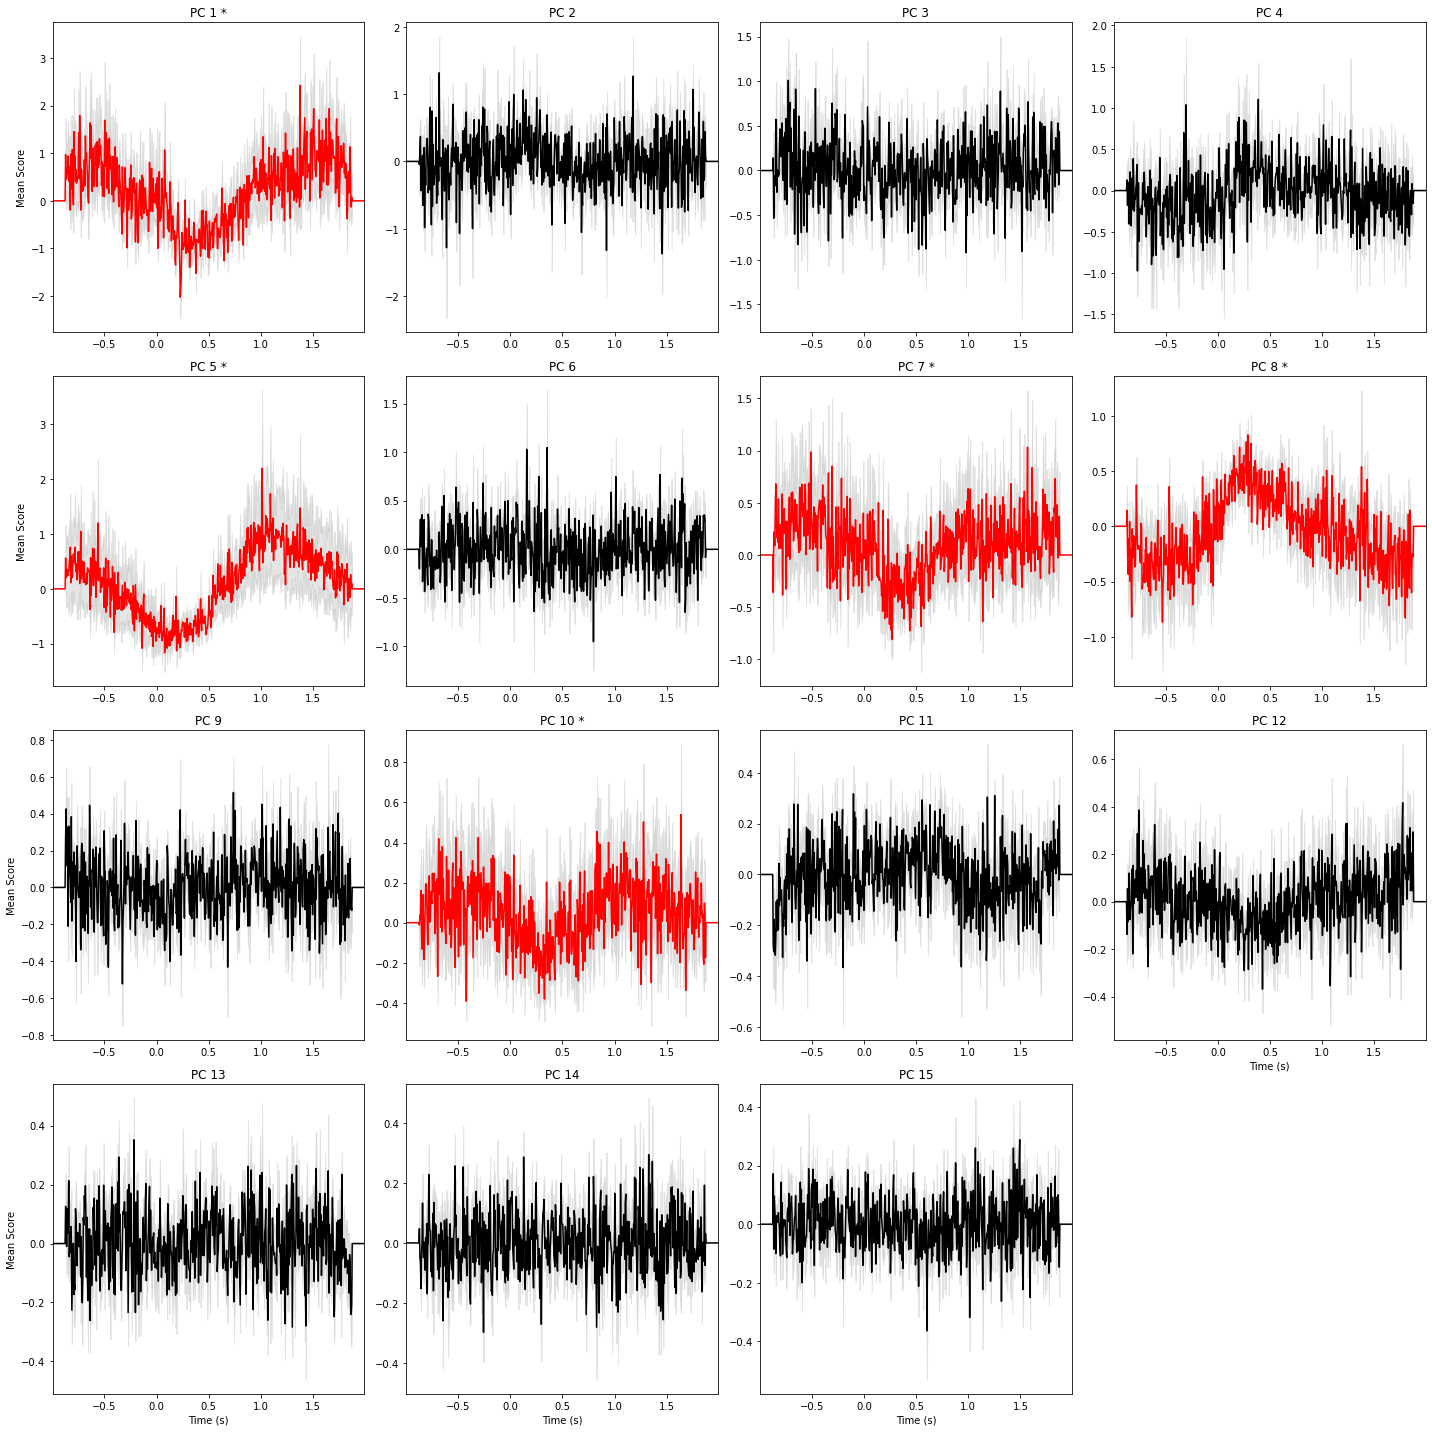

In [30]:
observed_variances_c3, significant_pcs_c3 = score_var_permutation_test(c3_shuffling_results, c3_idx)

Significant PCs: [5, 6, 7, 8]


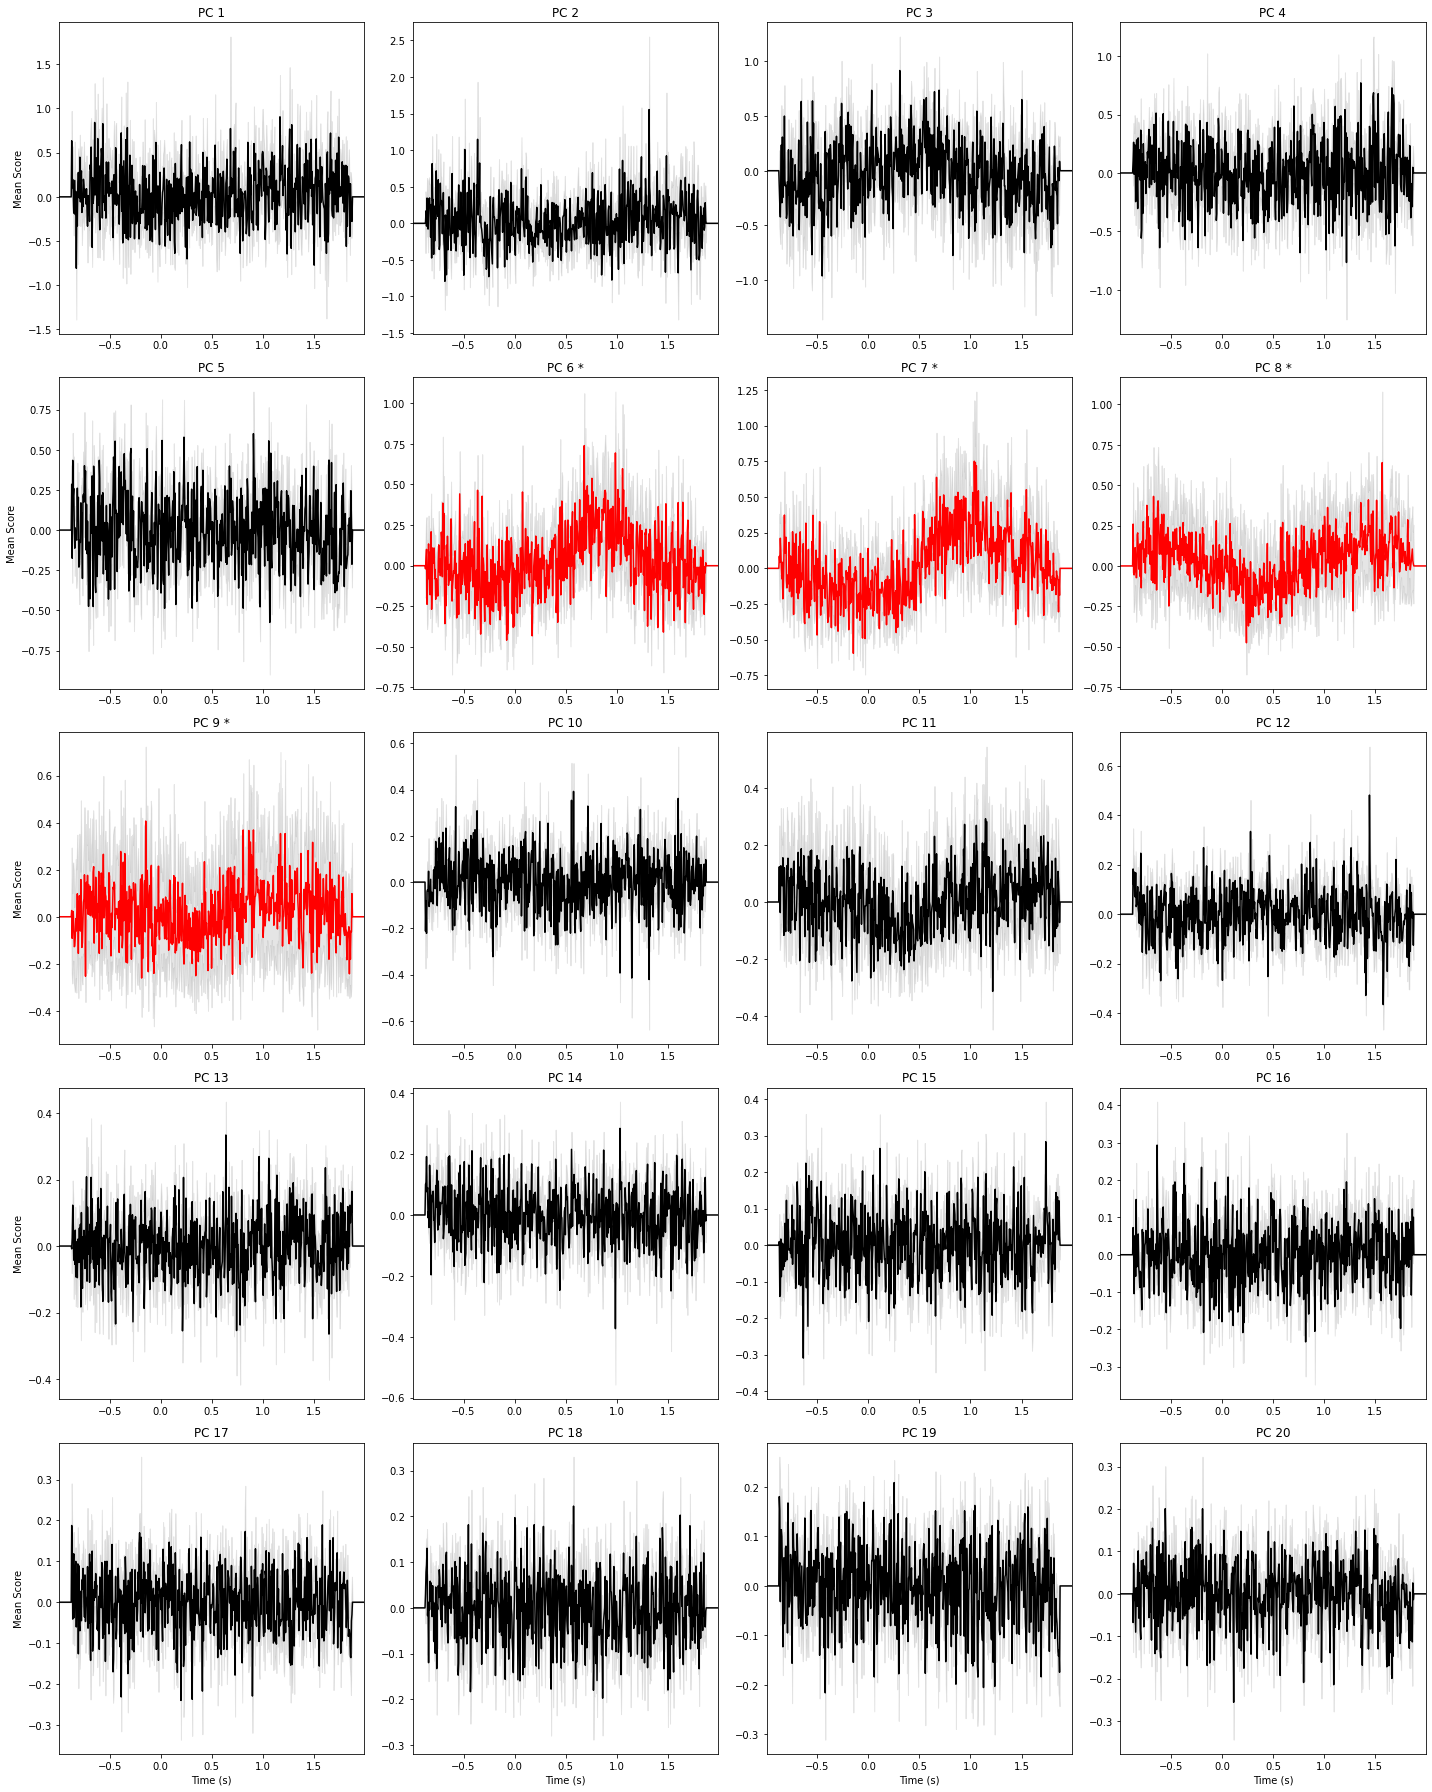

In [31]:
observed_variances_f4, significant_pcs_f4 = score_var_permutation_test(f4_shuffling_results, f4_idx)

Text(0, 0.5, 'Variance of the mean')

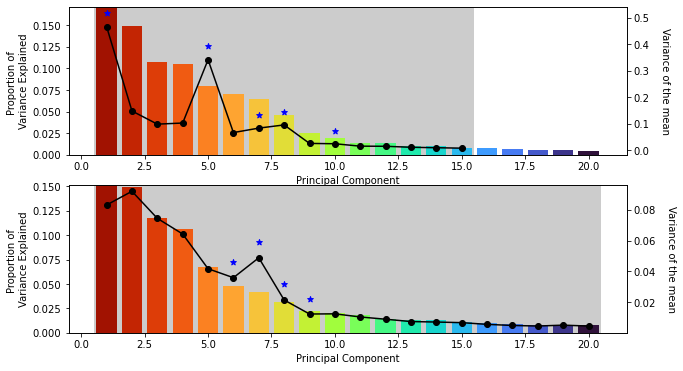

In [33]:
fig = plt.figure(figsize=(10,6))

ax = plt.subplot(2, 1, 1)
PC_var_exp = model_laplac_C3.explained_variance_ratio_
PC_r = np.arange(PC_var_exp.shape[0]) + 1
shuf_plot=np.zeros(PC_var_exp.shape[0])
shuf_plot[c3_shuffling_results]=np.max(PC_var_exp)
bar = ax.bar(PC_r, shuf_plot, lw=0.2, color="black", alpha=0.2, width=1)
bar = ax.bar(PC_r, PC_var_exp, lw=0.2)
cm = plt.cm.get_cmap("turbo_r")
for i in PC_r:
    plt.setp(bar[i-1],"facecolor", cm(i/20))
ax.set_xlabel("Principal Component")
ax.set_ylabel("Proportion of \nVariance Explained")
ax.set_ylim([0, PC_var_exp[0]])
ax2 = ax.twinx()
ax2.scatter(c3_shuffling_results+1, [observed_variances_c3[x] for x in c3_shuffling_results], color='k')
ax2.plot(c3_shuffling_results+1, [observed_variances_c3[x] for x in c3_shuffling_results], color='k')
ax2.scatter(np.array(significant_pcs_c3)+1, [observed_variances_c3[x]+.05 for x in significant_pcs_c3],marker='*',color='b')
ax2.set_ylabel("Variance of the mean", rotation=-90, labelpad=20)

ax = plt.subplot(2, 1, 2)
PC_var_exp = model_laplac_F4.explained_variance_ratio_
PC_r = np.arange(PC_var_exp.shape[0]) + 1
shuf_plot=np.zeros(PC_var_exp.shape[0])
shuf_plot[f4_shuffling_results]=np.max(PC_var_exp)
bar = ax.bar(PC_r, shuf_plot, lw=0.2, color="black", alpha=0.2, width=1)
bar = ax.bar(PC_r, PC_var_exp, lw=0.2)
cm = plt.cm.get_cmap("turbo_r")
for i in PC_r:
    plt.setp(bar[i-1],"facecolor", cm(i/20))
ax.set_xlabel("Principal Component")
ax.set_ylabel("Proportion of \nVariance Explained")
ax.set_ylim([0, PC_var_exp[0]])
ax2 = ax.twinx()
ax2.scatter(f4_shuffling_results+1, [observed_variances_f4[x] for x in f4_shuffling_results], color='k')
ax2.plot(f4_shuffling_results+1, [observed_variances_f4[x] for x in f4_shuffling_results], color='k')
ax2.scatter(np.array(significant_pcs_f4)+1, [observed_variances_f4[x]+.01 for x in significant_pcs_f4],marker='*',color='b')
ax2.set_ylabel("Variance of the mean", rotation=-90, labelpad=20)


In [52]:
def stat_fun(*args):
    return f_mway_rm(
        np.swapaxes(args, 0, 0),
        factor_levels=[3],
        effects='A',
        return_pvals=False,
    )[0]

def plot_pc_burst_rate(pc_idx, b_idx):
    n_q = 3
    step = 100 / n_q
    q_bins = np.percentile(all_burst_pc_scores[:, pc_idx], np.arange(0, 100 + step, step))

    time_bin_size = 0.02
    time_bins = np.arange(-1, 2 + time_bin_size, time_bin_size)

    q_rates_smoothed = {q: {'FS': [], 'SS': [], 'GO': []} for q in range(n_q)}
    subjects=np.unique(all_bursts['subject'])

    # Calculate smoothed burst rates by quantile x condition x subject
    for subject in subjects:
        subj_idx = b_idx & (all_bursts['subject'] == subject)
        for q in range(n_q):
            q_idx = ((all_burst_pc_scores[:, pc_idx] >= q_bins[q]) &
                     (all_burst_pc_scores[:, pc_idx] <= q_bins[q+1]))
            for cond in ['FS', 'SS', 'GO']:
                cond_trials = np.unique(
                    all_bursts['trial'][subj_idx & (all_bursts['condition'] == cond)]
                )
                unsmoothed_rate, _ = np.histogram(
                    all_bursts['peak_time'][subj_idx & (all_bursts['condition'] == cond) & q_idx],
                    bins=time_bins
                )
                # Convert to rate
                unsmoothed_rate = (unsmoothed_rate / time_bin_size) / len(cond_trials)

                smoothed_rate = gaussian_filter(unsmoothed_rate, sigma=2)
                base_idx = np.where((time_bins >= -0.6) & (time_bins < 0))[0]
                base_rate = np.mean(smoothed_rate[base_idx])
                smoothed_rate = smoothed_rate - base_rate

                q_rates_smoothed[q][cond].append(smoothed_rate)

    # Truncate last bin
    time_bins = time_bins[:-1]
    idx = np.where((time_bins >= -0.6) & (time_bins <= 1.6))[0]
    time_bins = time_bins[idx]

    # Convert each quantile+condition?s list of arrays to np arrays
    for q in range(n_q):
        for cond in ['FS', 'SS', 'GO']:
            q_rates_smoothed[q][cond] = np.vstack(q_rates_smoothed[q][cond])[:, idx]

    plt.figure(figsize=(18, 3))
    plt.rcParams.update({
        'font.size': 16,
        'axes.spines.right': False,
        'axes.spines.top': False,
        'xtick.major.size': 6,
        'xtick.major.width': 1.2,
        'ytick.major.size': 6,
        'ytick.major.width': 1.2,
        'legend.frameon': False,
        'legend.handletextpad': 0.1,
        'svg.fonttype': 'none',
        'text.usetex': False
    })

    # For each quantile, do a 1x3 repeated-measures ANOVA across time
    for q in range(n_q):
        ax = plt.subplot(1, 3, q + 1)

        # Plot grand averages for each condition
        for cond in ['FS', 'SS', 'GO']:
            mean_rate = np.mean(q_rates_smoothed[q][cond], axis=0)
            sem_rate = np.std(q_rates_smoothed[q][cond], axis=0) / np.sqrt(q_rates_smoothed[q][cond].shape[0])
            ax.plot(time_bins, mean_rate, label=cond)
            ax.fill_between(time_bins, mean_rate - sem_rate, mean_rate + sem_rate, alpha=0.2)

        # X shape: (n_subjects, n_conditions, n_times)
        X = np.stack((
            q_rates_smoothed[q]['FS'],
            q_rates_smoothed[q]['SS'],
            q_rates_smoothed[q]['GO']
        ), axis=1)
        
        # For a one-way repeated-measures ANOVA with 3 levels, define factor_levels=[3].
        # We will test effect 'A' (the only factor).
        factor_levels = [3]
        effects = 'A'  # Single factor

        # Compute threshold for cluster test
        threshold = f_threshold_mway_rm(
            n_subjects=X.shape[0],
            factor_levels=factor_levels,
            effects=effects
        )

        # Run cluster-based permutation on F-stat
        f_obs, clusters, cluster_p_values, H0 = spatio_temporal_cluster_test(
            X,
            threshold=threshold,
            stat_fun=stat_fun,
            n_permutations=10000,
            tail=1.0,
            n_jobs=-1
        )

        # Mark significant cluster spans
        for (c_inds,), p_val in zip(clusters, cluster_p_values):
            if p_val < 0.05:  # cluster-level alpha
                # c_inds is a slice or range of time indices
                ax.axvspan(
                    time_bins[c_inds[0]], 
                    time_bins[c_inds[-1]],
                    color='yellow', alpha=0.2
                )

        ax.set_xlabel("Task time (s)")
        if q==0:
            ax.set_ylabel("Burst rate")
            plt.legend()

    plt.tight_layout()

stat_fun(H1): min=0.041584 max=4.892007
Running initial clustering
Found 4 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
stat_fun(H1): min=0.000687 max=7.612578
Running initial clustering
Found 3 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
stat_fun(H1): min=0.016016 max=17.370033
Running initial clustering
Found 5 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
stat_fun(H1): min=0.014357 max=13.274690
Running initial clustering
Found 2 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
stat_fun(H1): min=0.000263 max=9.810688
Running initial clustering
Found 5 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
stat_fun(H1): min=0.081084 max=13.317748
Running initial clustering
Found 5 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
stat_fun(H1): min=0.026526 max=5.052386
Running initial clustering
Found 2 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
stat_fun(H1): min=0.001643 max=4.572383
Running initial clustering
Found 1 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
stat_fun(H1): min=0.132004 max=8.985351
Running initial clustering
Found 6 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
stat_fun(H1): min=0.004739 max=11.955355
Running initial clustering
Found 2 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
stat_fun(H1): min=0.023003 max=5.463999
Running initial clustering
Found 6 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
stat_fun(H1): min=0.000782 max=4.096461
Running initial clustering
Found 3 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
stat_fun(H1): min=0.023280 max=7.945222
Running initial clustering
Found 5 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
stat_fun(H1): min=0.002738 max=7.339287
Running initial clustering
Found 2 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
stat_fun(H1): min=0.001332 max=8.196022
Running initial clustering
Found 4 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


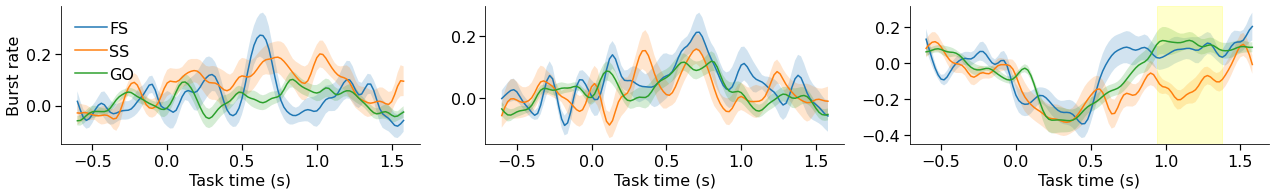

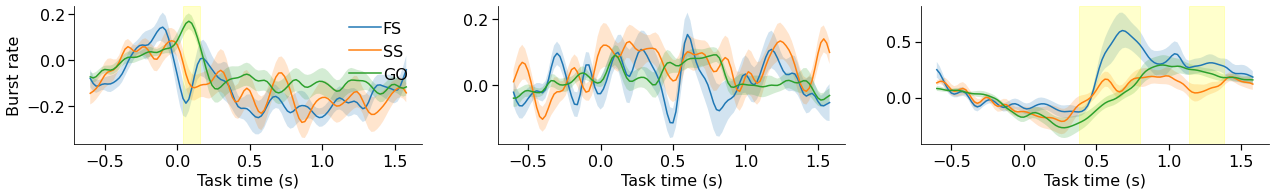

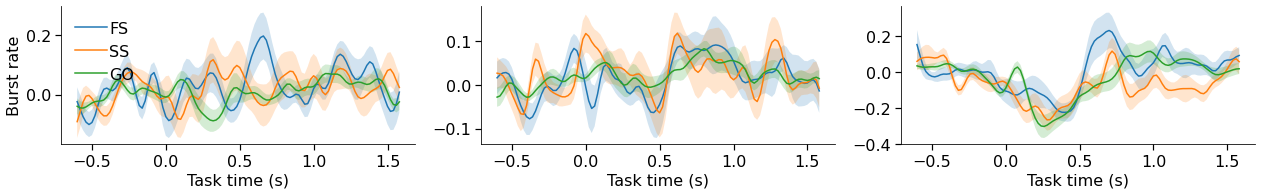

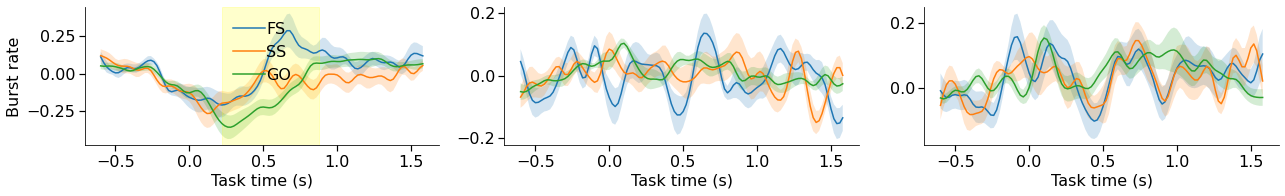

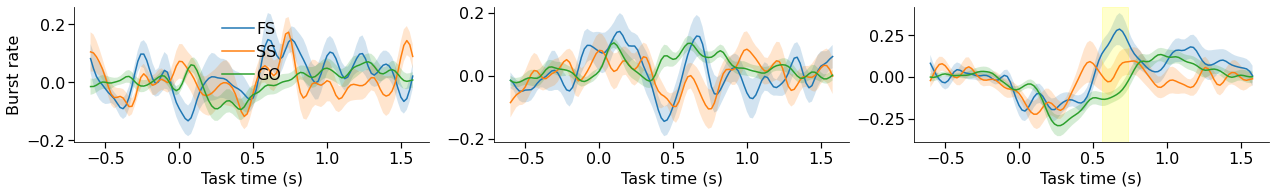

In [53]:
for pc_idx in significant_pcs_c3:
    plot_pc_burst_rate(pc_idx, c3_idx)

stat_fun(H1): min=0.004504 max=5.999133
Running initial clustering
Found 1 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
stat_fun(H1): min=0.001275 max=7.157288
Running initial clustering
Found 3 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
stat_fun(H1): min=0.025720 max=11.707707
Running initial clustering
Found 7 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
stat_fun(H1): min=0.006343 max=1.982174
Running initial clustering
Found 0 clusters


/home/bonaiuto/tmp/ipykernel_32556/2692498961.py:100: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  f_obs, clusters, cluster_p_values, H0 = spatio_temporal_cluster_test(


stat_fun(H1): min=0.010125 max=5.748780
Running initial clustering
Found 3 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
stat_fun(H1): min=0.007339 max=6.951640
Running initial clustering
Found 3 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
stat_fun(H1): min=0.000925 max=6.240449
Running initial clustering
Found 1 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
stat_fun(H1): min=0.008318 max=3.962737
Running initial clustering
Found 1 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
stat_fun(H1): min=0.014208 max=7.881901
Running initial clustering
Found 3 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
stat_fun(H1): min=0.017240 max=16.412223
Running initial clustering
Found 4 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
stat_fun(H1): min=0.043414 max=5.405573
Running initial clustering
Found 1 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
stat_fun(H1): min=0.000044 max=7.978338
Running initial clustering
Found 3 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


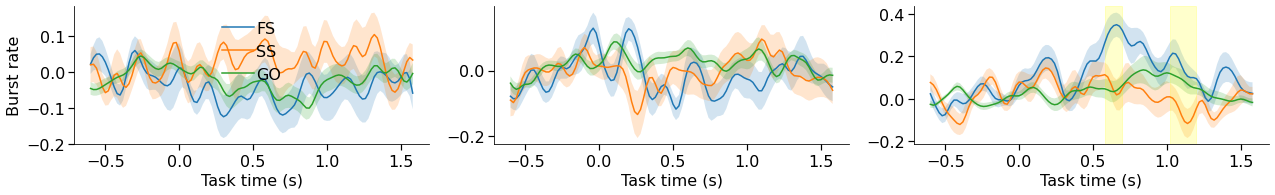

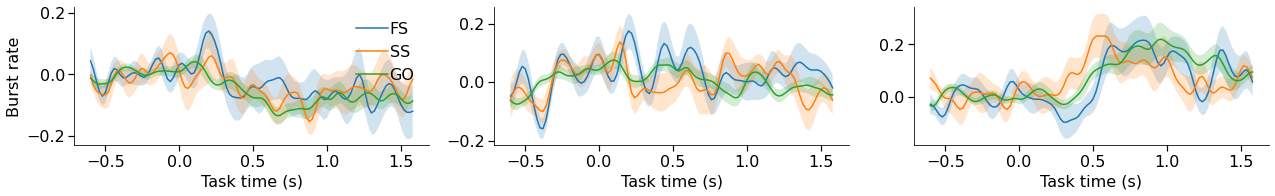

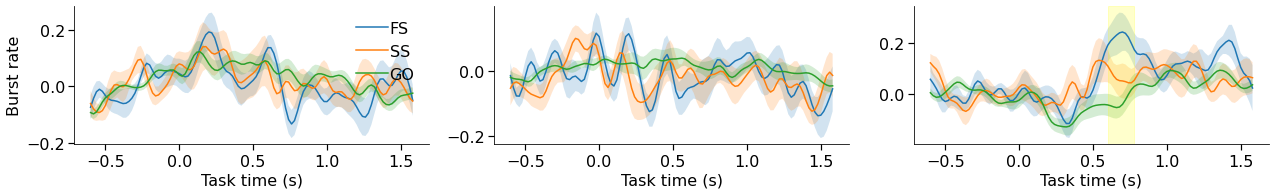

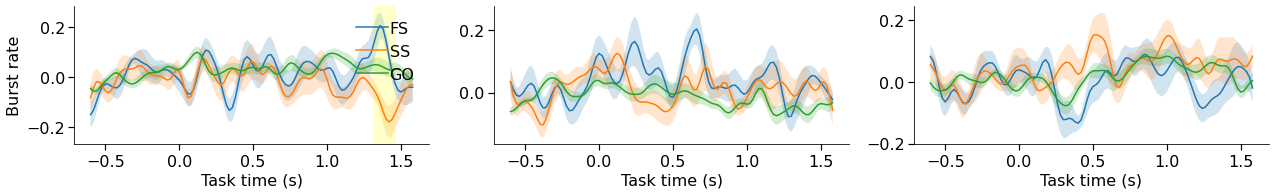

In [54]:
for pc_idx in significant_pcs_f4:
    plot_pc_burst_rate(pc_idx, f4_idx)